In [1]:
import numpy as np 
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import SparsePCA
import re
from nltk.corpus import stopwords

# data upload 

In [2]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')
test_labels=pd.read_csv('test_labels.csv')
smpsub=pd.read_csv('sample_submission.csv')

In [3]:
train1=pd.DataFrame(train)
train1=train1.drop(['id','comment_text'],axis=1)

In [4]:
train1['target']= 0

In [5]:
for index, row in train1.iterrows():
    a = row['toxic']+row['severe_toxic']+row['obscene']+row['threat']+row['insult']+row['identity_hate']
    if a>=1:
        row['target'] = 1
    else:
        row['target'] = 0                        

In [6]:
train2=train1.drop(['toxic','severe_toxic','obscene','threat','insult','identity_hate'],axis=1)

In [7]:
train3=train.drop(['toxic','severe_toxic','obscene','threat','insult','identity_hate','id'],axis=1)

In [8]:
train4=train3.join(train2)

In [9]:
y = train4['target']
xtrain, xvalid, ytrain, yvalid = train_test_split(train4.comment_text.values, y, stratify=y,random_state=42, 
                                                  test_size=0.1, shuffle=True)

# train and test split with single taregt column, describing toxic(1) and non toxic(0) command

In [10]:
# load the GloVe vectors in a dictionary:
from tqdm import tqdm
import numpy as np
import pandas as pd

embeddings_index = {}
f = open('glove.840B.300d.txt',encoding='utf8')
for line in tqdm(f):
    values = line.split()
    word = values[0]
    try:
        coefs = np.array(values[1:], dtype='float32')
    except ValueError:
        pass
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

2196017it [03:33, 10262.97it/s]


Found 2195884 word vectors.


In [11]:
# this function creates a normalized vector for the whole sentence
def sent2vec(s):
    words = str(s).lower()#.decode('utf-8')
    words = word_tokenize(words)
    words = [w for w in words if not w in stop_words]
    words = [w for w in words if w.isalpha()]
    M = []
    for w in words:
        try:
            M.append(embeddings_index[w])
        except:
            continue
    M = np.array(M)
    v = M.sum(axis=0)
    if type(v) != np.ndarray:
        return np.zeros(300)
    return v / np.sqrt((v ** 2).sum())

In [12]:
from nltk import word_tokenize
import nltk
nltk.download('punkt')

from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = stopwords.words('english')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\root\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\root\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
# create sentence vectors using the above function for training and validation set
xtrain_glove = [sent2vec(x) for x in tqdm(xtrain)]
xvalid_glove = [sent2vec(x) for x in tqdm(xvalid)]

100%|██████████| 15958/15958 [00:15<00:00, 1017.70it/s]


comments are converted to glove vectors

In [16]:
ytrain.value_counts()

0    129011
1     14602
Name: target, dtype: int64

In [17]:
yvalid.value_counts()

0    14335
1     1623
Name: target, dtype: int64

In [18]:
from imblearn.over_sampling import SMOTE 
import smote
import rus
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.utils import resample



def adaboost(X_train, X_test, y_train):
    model = AdaBoostClassifier(n_estimators=100, random_state=42)
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    return y_pred

In [19]:
# AdaBoost
y_baseline = adaboost(xtrain_glove, xvalid_glove, ytrain)


# simple adaboost implementation on dataset with roc curve

In [20]:
print(classification_report(yvalid, y_baseline))

             precision    recall  f1-score   support

          0       0.96      0.98      0.97     14335
          1       0.79      0.63      0.70      1623

avg / total       0.94      0.95      0.94     15958



0.805739606859


Text(0.5,0,'False Positive Rate')

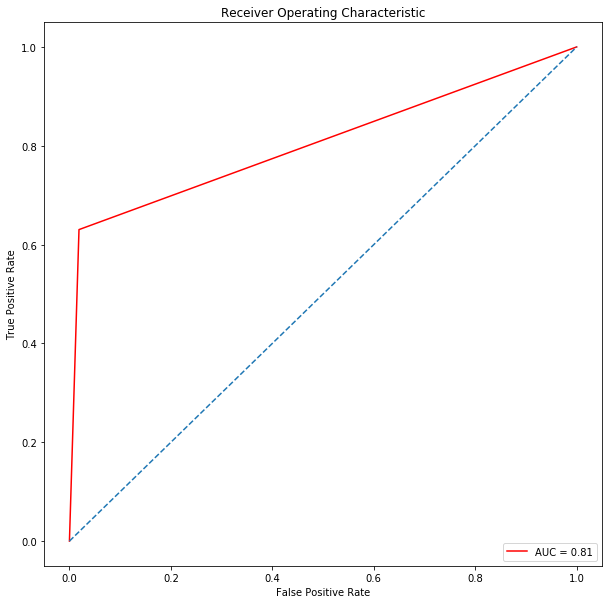

In [26]:
from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(yvalid, y_baseline)
roc_auc = auc(false_positive_rate, true_positive_rate)
print(roc_auc)

import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

# (smote + adaboost) implementation on dataset with roc curve

In [27]:
# SMOTE
sm = SMOTE(random_state=42)
X_train_sm, y_train_sm = sm.fit_sample(xtrain_glove, ytrain)
y_smote = adaboost(X_train_sm, xvalid_glove, y_train_sm)

In [31]:
print(classification_report(yvalid, y_smote))

             precision    recall  f1-score   support

          0       0.98      0.92      0.95     14335
          1       0.53      0.80      0.64      1623

avg / total       0.93      0.91      0.91     15958



0.860602075028


Text(0.5,0,'False Positive Rate')

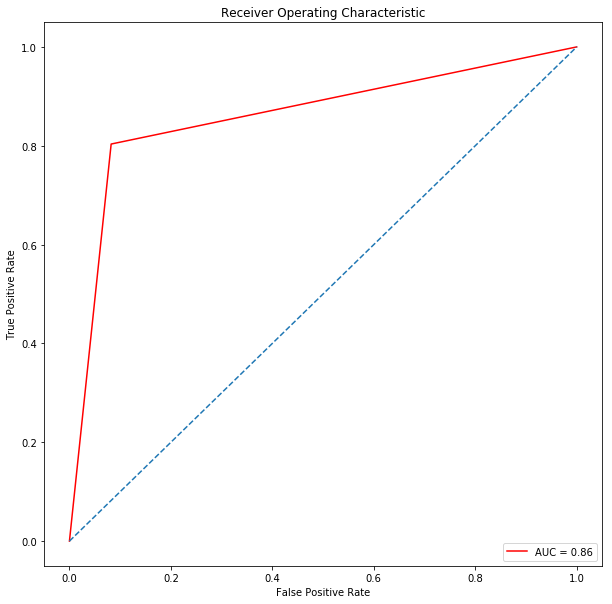

In [29]:
from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(yvalid, y_smote)
roc_auc = auc(false_positive_rate, true_positive_rate)
print(roc_auc)

import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

# (rus+adaboost) implementation on dataset with roc curve

In [30]:
import rus
# RUS
X_full = xtrain_glove.copy()
ytrain=np.array(ytrain)
ytrain=ytrain.reshape(143613, 1)
X_full=np.append(X_full, ytrain, axis=1)
X_full=pd.DataFrame(X_full)
X_maj = X_full[X_full.loc[:,300]==0]
X_min = X_full[X_full.loc[:,300]==1]
X_maj_rus = resample(X_maj,replace=False,random_state=44)
X_rus = pd.concat([X_maj_rus, X_min])
X_train_rus = X_rus.drop([300], axis=1)
y_train_rus = X_rus.loc[:,300]
y_rus = adaboost(X_train_rus, xvalid_glove, y_train_rus)

In [32]:
print(classification_report(yvalid, y_rus))

             precision    recall  f1-score   support

          0       0.96      0.98      0.97     14335
          1       0.79      0.63      0.70      1623

avg / total       0.94      0.95      0.94     15958



0.805739606859


Text(0.5,0,'False Positive Rate')

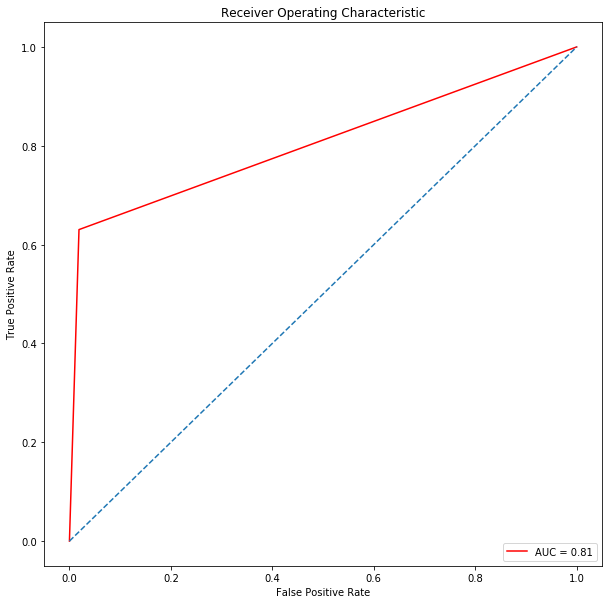

In [33]:
from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(yvalid, y_rus)
roc_auc = auc(false_positive_rate, true_positive_rate)
print(roc_auc)

import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

# smoteboost and rusboost algo implementation

C:\Users\root\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



SMOTEBoost(algorithm='SAMME.R', base_estimator=None, k_neighbors=None,
      learning_rate=1.0, n_estimators=100, n_samples=300,
      random_state=None)

             precision    recall  f1-score   support

          0       0.97      0.97      0.97     14335
          1       0.72      0.69      0.71      1623

avg / total       0.94      0.94      0.94     15958

0.831029921509


C:\Users\root\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



RUSBoost(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
     min_ratio=1.0, n_estimators=100, n_samples=300, random_state=None,
     with_replacement=None)

             precision    recall  f1-score   support

          0       0.97      0.95      0.96     14335
          1       0.63      0.75      0.68      1623

avg / total       0.94      0.93      0.93     15958

0.847926314719


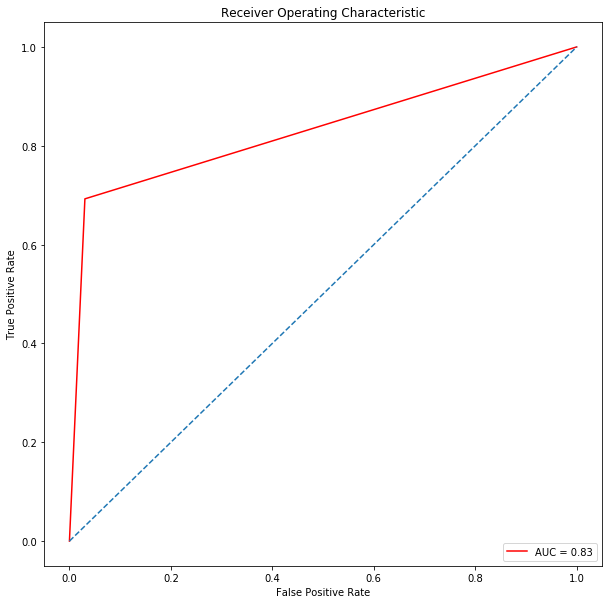

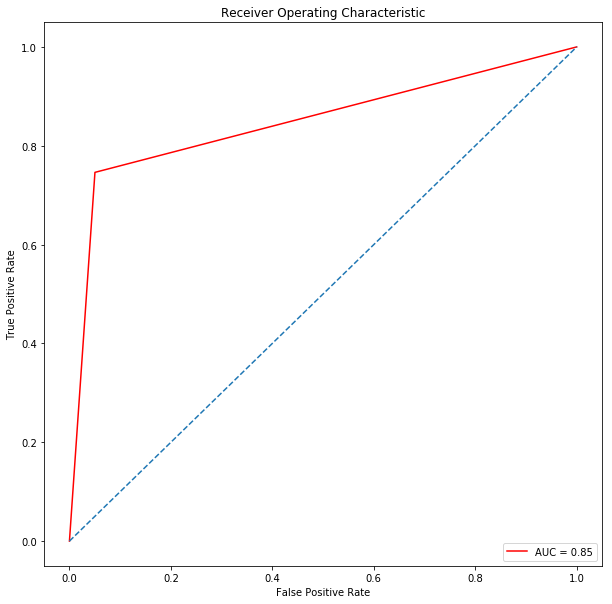

In [34]:
# smote.SMOTEBoost(n_estimators=100, n_samples=300).fit(xtrain_glove, ytrain)
# y_pred_sm = smote.SMOTEBoost(n_estimators=100, n_samples=300).predict(xvalid_glove)

for algorithm in [smote.SMOTEBoost(n_estimators=100, n_samples=300),
                  rus.RUSBoost(n_estimators=100, n_samples=300)]:
    algorithm.fit(xtrain_glove, ytrain)
    y_pred = algorithm.predict(xvalid_glove)
    print()
    print(str(algorithm))
    print()
    print(classification_report(yvalid, y_pred))
    from sklearn.metrics import roc_curve, auc
    false_positive_rate, true_positive_rate, thresholds = roc_curve(yvalid, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    print(roc_auc)

    import matplotlib.pyplot as plt
    plt.figure(figsize=(10,10))
    plt.title('Receiver Operating Characteristic')
    plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],linestyle='--')
    plt.axis('tight')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')

# Xgboost implimentation

In [35]:
import xgboost as xgb
from xgboost import XGBClassifier
def xgboost(X_train, X_test, y_train):
    model = XGBClassifier(n_estimators=100)
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    return y_pred

In [40]:
xtrain_glove_1=np.array(xtrain_glove)

In [41]:
# xgBoost
y_baseline_xgb = xgboost(xtrain_glove_1, xvalid_glove, ytrain)

C:\Users\root\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\root\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [42]:
print(classification_report(yvalid, y_baseline_xgb))

             precision    recall  f1-score   support

          0       0.95      0.99      0.97     14335
          1       0.85      0.57      0.68      1623

avg / total       0.94      0.95      0.94     15958



0.781297708365


Text(0.5,0,'False Positive Rate')

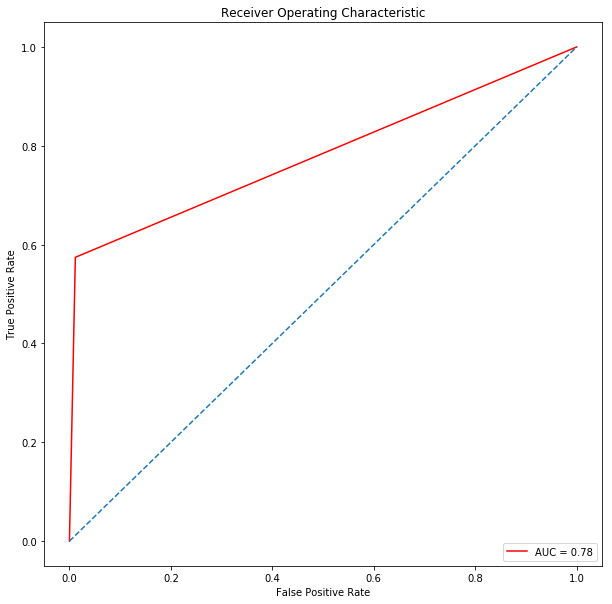

In [43]:
from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(yvalid, y_baseline_xgb)
roc_auc = auc(false_positive_rate, true_positive_rate)
print(roc_auc)
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

## Xgboost + smote algo

In [44]:
# SMOTE
sm = SMOTE(random_state=42)
X_train_sm, y_train_sm = sm.fit_sample(xtrain_glove, ytrain)
y_smote_xgb = xgboost(X_train_sm, xvalid_glove, y_train_sm)

C:\Users\root\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [45]:
print(classification_report(yvalid, y_smote_xgb))

             precision    recall  f1-score   support

          0       0.98      0.92      0.95     14335
          1       0.55      0.81      0.65      1623

avg / total       0.93      0.91      0.92     15958



0.867298583903


Text(0.5,0,'False Positive Rate')

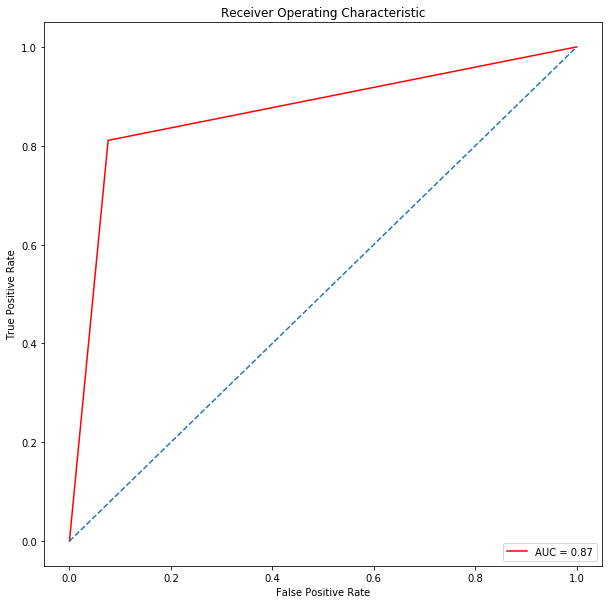

In [46]:
from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(yvalid, y_smote_xgb)
roc_auc = auc(false_positive_rate, true_positive_rate)
print(roc_auc)
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

## rus + Xgboost

In [47]:
import rus
# RUS
X_full = xtrain_glove.copy()
ytrain=np.array(ytrain)
ytrain=ytrain.reshape(143613, 1)
X_full=np.append(X_full, ytrain, axis=1)
X_full=pd.DataFrame(X_full)
xvalid_glove=pd.DataFrame(xvalid_glove)
X_maj = X_full[X_full.loc[:,300]==0]
X_min = X_full[X_full.loc[:,300]==1]
X_maj_rus = resample(X_maj,replace=False,random_state=44)
X_rus = pd.concat([X_maj_rus, X_min])
X_train_rus = X_rus.drop([300], axis=1)
y_train_rus = X_rus.loc[:,300]
y_rus_xgb = xgboost(X_train_rus, xvalid_glove, y_train_rus)

In [48]:
print(classification_report(yvalid, y_rus_xgb))

             precision    recall  f1-score   support

          0       0.95      0.99      0.97     14335
          1       0.85      0.57      0.68      1623

avg / total       0.94      0.95      0.94     15958



0.781297708365


Text(0.5,0,'False Positive Rate')

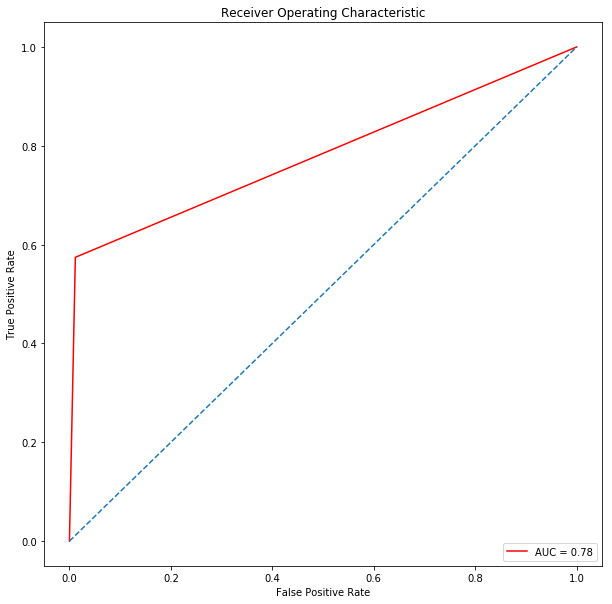

In [49]:
from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(yvalid, y_rus_xgb)
roc_auc = auc(false_positive_rate, true_positive_rate)
print(roc_auc)
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')